# Часть 1

## Этап 1

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causalml.inference.meta import BaseTClassifier, BaseXClassifier
import optuna


from sklift.metrics import uplift_auc_score, qini_auc_score, uplift_at_k
from sklift.viz import plot_qini_curve, plot_uplift_curve

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('uplift_fp_data.csv')

## Этап 2

### EDA


In [3]:
def data_summary(df: pd.DataFrame, name: str):
    '''
        Display a quick overview of a Polars DataFrame.
    '''
    print('\n' + '='*50)
    print(f'\n{name}')
    print('='*50)
  
    # Sample rows
    print('\nSample rows:')
    display(df.head())

    # Shape
    rows, cols = df.shape
    print(f'\nShape: {rows:,} rows x {cols} columns')
    
    # Data info
    print('\nSummary for numeric columns:')
    display(df.describe())
   
    # Column info
    print('\nColumn names and types:')
    for col in df.columns:
        print(f'  {col}: {df[col].dtype}')
    
    # Missing values
    print('\nMissing values:')
    display(df.isnull().sum())

    # Duplicated values
    print('\nDuplicated values:')
    display(f'{df.duplicated().sum()} duplicated values')
    duplicated_values = df[df.duplicated()]
    display(duplicated_values)

In [4]:
data_summary(df, 'A/B test results')



A/B test results

Sample rows:


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0



Shape: 64,000 rows x 10 columns

Summary for numeric columns:


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,1.481969,242.085656,0.551031,0.549719,0.748469,0.502250,1.319609,0.334172,0.146781
std,3.507592,1.544514,256.158608,0.497393,0.497526,0.697936,0.499999,0.678254,0.471704,0.353890
min,1.000000,0.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,64.660000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,6.000000,1.000000,158.110000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,2.000000,325.657500,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,12.000000,6.000000,3345.930000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000



Column names and types:
  recency: int64
  history_segment: int64
  history: float64
  mens: int64
  womens: int64
  zip_code: int64
  newbie: int64
  channel: int64
  treatment: int64
  target: int64

Missing values:


recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64


Duplicated values:


'7015 duplicated values'

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
149,2,0,29.99,0,1,1,0,1,0,0
167,7,0,29.99,1,0,1,1,2,1,0
526,10,0,29.99,1,0,0,0,2,1,0
606,10,0,29.99,1,0,1,1,2,0,0
654,10,0,29.99,1,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
63952,10,0,29.99,1,0,2,1,2,0,0
63955,1,0,29.99,1,0,1,0,1,0,0
63977,8,0,29.99,0,1,1,0,2,0,1
63982,5,0,29.99,1,0,0,1,1,0,0


In [5]:
#df = df.astype({
#    'history_segment': 'category', 
#    'mens': 'bool',
#    'womens': 'bool',
#    'zip_code': 'category',
#    'newbie': 'bool',
#    'channel': 'category',
#    'treatment': 'bool', 
#    'target': 'bool'
#})
#df.info()
#df.describe()
#df.isnull().sum()
#df.duplicated().sum()

In [6]:
grouped_data = (
    df
        .groupby('treatment')['target']
        .agg(['mean', 'count'])
)
display(grouped_data)

,mean,count
treatment,,
0,0.144463,42613
1,0.151400,21387


Сделайте вывод на основе EDA в данной ячейке

# Этап 2

### Проверка на статистическую значимость

Обоснуйте выбор статистического теста в данной ячейке

In [7]:
def z_test_one_sided(
    df: pd.DataFrame, 
    treatment_col: str, 
    target_col: str,
    alternative: str,
    alpha: float = 0.05) -> dict:
    '''
    One-sided z-test for difference in conversion rates between
    test group (that received treatment) and control group (that did not receive treatment).

    Hypotheses:
    H0: p_treatment <= p_control (test group has lower or equal conversion rate than control group)
    H1: p_treatment > p_control (test group has higher conversion rate than control group)
    '''

    # Split groups
    control = df[df[treatment_col] == False]
    treatment = df[df[treatment_col] == True]

    # Counts and conversions
    n_c = len(control)
    n_t = len(treatment)
    conv_c = control[target_col].sum() # number of conversions in control group
    conv_t = treatment[target_col].sum() # number of conversions in test group

    # Conversion rates
    p_c = conv_c / n_c # conversion rate in control group
    p_t = conv_t / n_t # conversion rate in test group

    # Standard error of the difference in conversion rates (assuming independency, normal approximation)
    se = np.sqrt(p_t * (1 - p_t) / n_t + p_c * (1 - p_c) / n_c)

    # Avoid division by zero
    if se == 0:
        raise ValueError('Standard error is zero; check data (no variation).')

    # z-statistic
    z = (p_t - p_c) / se

    # One-sided p-value
    if alternative == 'greater':
        p_value = 1 - stats.norm.cdf(z)   # P-value for the right-tailed z-test
    elif alternative == 'less':
        p_value = stats.norm.cdf(z)       # P-value for the left-tailed z-test
    else:
        raise ValueError('Alternative must be greater or less.')

    result = {
        'Conversion rate control group': p_c.round(3),
        'Conversion rate treatment group': p_t.round(3),
        'z-statistic': z.round(3),
        'p-value': p_value.round(3),
        'Number of observations control group': n_c,
        'Number of observations treatment group': n_t
    }

    print(f'Results of z-test:\n{result}')

    if result['p-value'] < alpha:
        print('Statistically significant uplift (reject H0: test group has lower or equal conversion rate than control group).')
    else:
        print('Not statistically significant (fail to reject H0: test group has lower or equal conversion rate than control group).')

    return result


In [8]:
result = z_test_one_sided(
    df, 
    treatment_col='treatment', 
    target_col='target',
    alternative='greater',
    alpha = 0.05)

Results of z-test:
{'Conversion rate control group': 0.144, 'Conversion rate treatment group': 0.151, 'z-statistic': 2.324, 'p-value': 0.01, 'Number of observations control group': 42613, 'Number of observations treatment group': 21387}
Statistically significant uplift (reject H0: test group has lower or equal conversion rate than control group).


## Построение корреляций

In [9]:
def plot_correlation_heatmap(
    df: pd.DataFrame, 
    exclude_cols: list = ['treatment'], 
    figsize: tuple = (12, 10), 
    cmap: str = 'coolwarm', 
    title: str = 'Correlation Map of Features'
):
    '''
        Plot correlation heatmap for numeric features in A/B test data.
    '''
    
    # Compute correlation matrix (numeric columns only, excluding specified)
    numeric_data = df.drop(columns=exclude_cols).select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr()
    
    print(f'Correlation matrix shape: {correlation_matrix.shape}')

    # Create plot
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, linewidths=0.5, center=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Top 10 strongest correlations excluding self-correlations
    # Create mask for upper triangle of correlation matrix
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    top_corrs = (
        correlation_matrix
            .abs()
            .where(~mask)  # Keep only upper triangle
            .unstack()
            .dropna()
            .sort_values(ascending=False)
            .head(10)
    )   
    print('Top 10 strongest correlations:')
    display(top_corrs)

    # Get all correlations with target excluding self-correlation
    corrs_target = (
        correlation_matrix['target']
            .drop('target', errors='ignore')
            .sort_values(ascending=False)
    )
    print('All correlations with target:')
    display(corrs_target)

    return correlation_matrix

Correlation matrix shape: (9, 9)


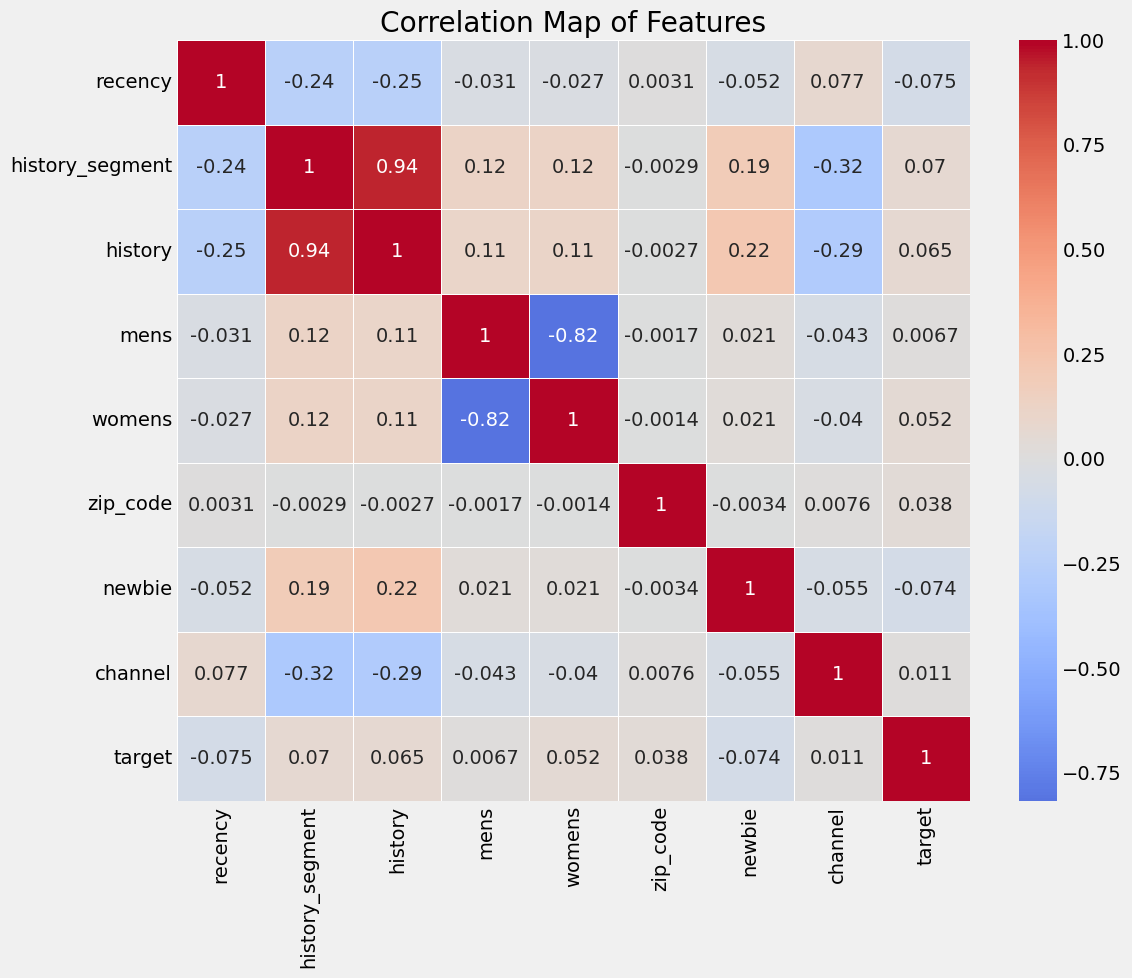

Top 10 strongest correlations:


history_segment  history            0.938582
mens             womens             0.816943
history_segment  channel            0.318429
history          channel            0.290378
recency          history            0.246591
                 history_segment    0.243782
history          newbie             0.223279
history_segment  newbie             0.187939
                 mens               0.120325
                 womens             0.120221
dtype: float64

All correlations with target:


history_segment    0.069734
history            0.065153
womens             0.051999
zip_code           0.037570
channel            0.010584
mens               0.006712
newbie            -0.073924
recency           -0.074765
Name: target, dtype: float64

In [10]:
corr_matrix = plot_correlation_heatmap(df)

Сделайте вывод о корреляциях признаков друг с другом и таргетом в этой ячейке

## Этап 3

Обоснуйте выбор конкретной uplift модели в данной ячейке

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

In [11]:
## 1. Prep data (encode categoricals + identify cat features for CatBoost)
#
#df_encoded = pd.get_dummies(df.drop(['treatment', 'target'], axis=1), drop_first=True)
#
#X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
#    df_encoded, df['treatment'], df['target'], 
#    test_size=0.2, random_state=42, stratify=df['treatment']
#)
#
## Map treatment to string labels (required for some causalml models like X-Learner)
#treatment_mapping = {0: 'control', 1: 'treatment'}
#t_train_mapped = t_train.map(treatment_mapping)
#t_test_mapped = t_test.map(treatment_mapping)

In [12]:
df = df.astype({
    'history_segment': 'category', 
    'mens': 'bool',
    'womens': 'bool',
    'zip_code': 'category',
    'newbie': 'bool',
    'channel': 'category',
    'treatment': 'bool', 
    'target': 'bool'
})

categorical_features = [
    'history_segment', 
    'mens', 
    'womens', 
    'zip_code', 
    'newbie', 
    'channel'
]

categorical_indices = [df.columns.get_loc(col) for col in categorical_features]

In [13]:
X = df.drop(['target'], axis=1)
y = df['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, 
                                        test_size=0.2, 
                                        stratify=df[['target', 'treatment']],
                                        random_state=42
                                        )

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 51200 samples
Test set: 12800 samples


### Обучение выбранного бейзлайна

Uplift AUC: 0.03
Qini AUC: 0.06
Uplift@30: 0.0426


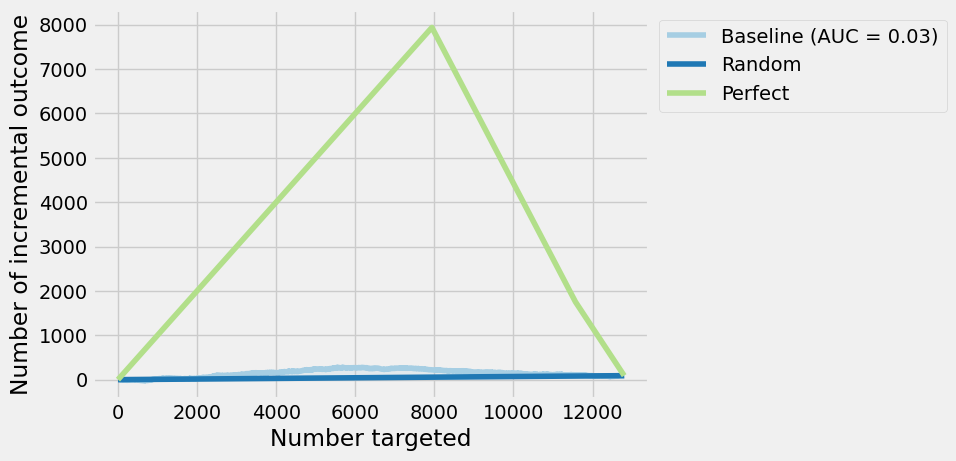

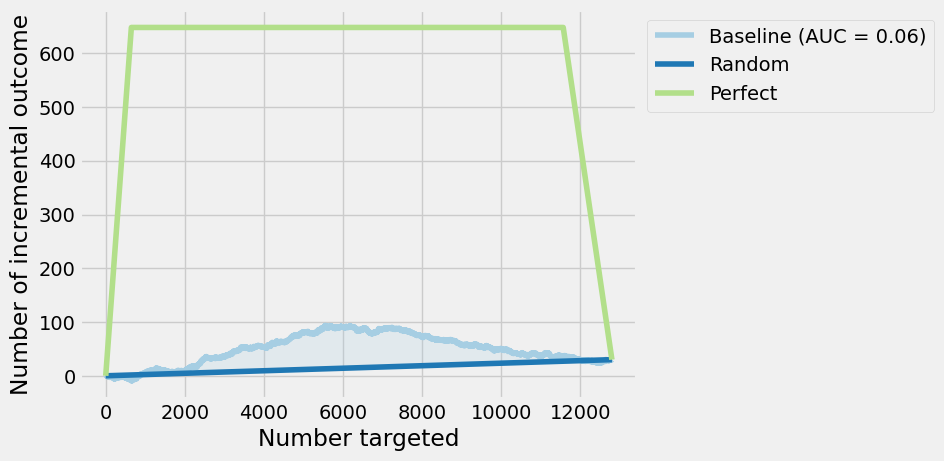

In [15]:
baseline_model = CatBoostClassifier(
                    cat_features=categorical_features,
                    iterations=500, 
                    depth=6, 
                    learning_rate=0.1,
                    auto_class_weights='Balanced', 
                    random_seed=42, 
                    verbose=0
                    )

baseline_model.fit(X_train, y_train)

# чтобы оценить uplift-эффекта для каждого пользователя:
# 1. Создаём копию тестовых данных
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

# 2. Устанавливаем значение признака treatment
X_test_treated['treatment'] = 1  # С воздействием
X_test_control['treatment'] = 0  # Без воздействия

# 3. Предсказываем результаты для обоих случаев
y_pred_treated = baseline_model.predict_proba(X_test_treated)[:,1]
y_pred_control = baseline_model.predict_proba(X_test_control)[:,1]

# 4. Вычисляем uplift как разницу между предсказаниями
uplift_pred_baseline = y_pred_treated - y_pred_control

# Добавляем предсказанный uplift к тестовым данным для анализа
X_test_predicted = X_test.copy()
X_test_predicted['predicted_uplift'] = uplift_pred_baseline

# рассчитываем метрики uplift
uplift_score = uplift_auc_score(
    y_test.values, 
    X_test_predicted['predicted_uplift'], 
    X_test['treatment'].values
)
qini_score = qini_auc_score(
    y_test.values, 
    X_test_predicted['predicted_uplift'],  
    X_test['treatment'].values
)
uplift_30 = uplift_at_k(
    y_test.values, 
    X_test_predicted['predicted_uplift'],  
    X_test['treatment'].values,
    strategy='overall',
    k=0.3
)

print(f"Uplift AUC: {uplift_score:.2f}")
print(f"Qini AUC: {qini_score:.2f}")
print(f"Uplift@30: {uplift_30:.4f}")

plot_uplift_curve(y_test,
    uplift_pred_baseline,
    X_test['treatment'].values, name='Baseline')
plt.show()

plot_qini_curve(y_test,
    uplift_pred_baseline, 
    X_test['treatment'].values, name='Baseline')
plt.show()

# it calculates the uplift for the top 30% of users most likely to respond to treatment.



In [16]:
# Extract feature importances
importances = baseline_model.get_feature_importance(type="PredictionValuesChange")
feature_names = baseline_model.feature_names_

In [17]:
# Create Pandas dataframe
catboost_feature_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

display(catboost_feature_importances)

,feature,importance
2,history,29.817504
0,recency,16.728142
5,zip_code,11.862450
7,channel,9.721410
6,newbie,9.698603
1,history_segment,7.277675
4,womens,5.742920
3,mens,4.880735
8,treatment,4.270559


# Обучение 2 моделей 

### Обучение модели 1

### T-Learner

In [18]:
class TLearner: 
    '''
        T-Learner with separate treatment and control models
    '''
    
    def __init__(self):
        '''
            Initialize models
        '''

        # CatBoostClassifier for treatment learners
        treatment_cb_clf = CatBoostClassifier(
                            iterations=500, 
                            depth=6, 
                            learning_rate=0.1,
                            auto_class_weights='Balanced', 
                            random_seed=42, 
                            verbose=0
                            )

        # CatBoostClassifier for control learner
        control_cb_clf = CatBoostClassifier(
                            iterations=500, 
                            depth=6, 
                            learning_rate=0.1,
                            auto_class_weights='Balanced', 
                            random_seed=42, 
                            verbose=0
                            )

        self.treatment_learner = treatment_cb_clf
        self.control_learner = control_cb_clf

    def fit(self, X_train, y_train, treatment):

        # Initialize T-learner with separate treatment and control models
        self.t_learner = BaseTClassifier(
            treatment_learner=self.treatment_learner,
            control_learner=self.control_learner,
            control_name=0
        )

        # Fit T-learner
        self.t_learner.fit(
            X=X_train.drop('treatment', axis=1).values,               
            treatment=X_train['treatment'].values,       
            y=y_train.astype(int).values
        )
    
    def predict(self, X_test):
        '''
            Predict uplift for test set
        '''

        uplift_pred_t = self.t_learner.predict(X_test.drop('treatment', axis=1).values)
        return uplift_pred_t

    def evaluate(self, y_test, X_test):
        '''
            Evaluate T-learner performance
        '''

        # Calculate uplift metrics
        uplift_score = uplift_auc_score(
                            y_test.astype(int).values,
                            self.uplift_pred_t.squeeze(),
                            X_test['treatment'].values
                        )
        print(f"Uplift AUC: {uplift_score:.2f}")

        # Calculate Qini AUC
        qini_score = qini_auc_score(
                        y_test.astype(int).values,
                        self.uplift_pred_t.squeeze(),
                        X_test['treatment'].values
                    )
        print(f"Qini AUC: {qini_score:.2f}")

        # Calculate uplift@30%
        uplift_30 = uplift_at_k(
                        y_test.astype(int).values,
                        self.uplift_pred_t.squeeze(),
                        X_test['treatment'].values,
                        strategy='overall',
                        k=0.3
                    )
        print(f"Uplift@30: {uplift_30:.4f}")

        # Plot uplift curve
        plot_uplift_curve(
            y_test.astype(int).values,
            self.uplift_pred_t.squeeze(),
            X_test['treatment'].values, 
            name='T-Learner'
            )
        plt.show()

        # Plot Qini curve
        plot_qini_curve(
            y_test.astype(int).values,
            self.uplift_pred_t.squeeze(), 
            X_test['treatment'].values, 
            name='T-Learner'
            )
        plt.show()

        return uplift_score, qini_score, uplift_30     


### Обучение модели 2

### X-learner

In [19]:
class XLearner:
    '''
        X-learner with propensity score computation
    '''
    
    def __init__(self, params_clf, params_rgs, control_name):
        '''
            Initialize models
        '''

        # CatBoostClassifier for outcome-models
        # No cat_features as causalml converts data to numpy arrays internally (no column names)
        cb_clf = CatBoostClassifier(**params_clf)

        # CatBoostRegressor for effect-models
        # No cat_features as causalml converts data to numpy arrays internally (no column names)
        cb_rgs = CatBoostRegressor(**params_rgs)
        
        self.outcome_learner = cb_clf
        self.control_name = control_name
        self.effect_learner = cb_rgs
        self.propensity_train = None
        self.propensity_test = None
        self.propensity_model = None  # Store the propensity model for inference

    def compute_propensity_scores(self, X_train, X_test, propensity_params=None):
        '''
            Compute propensity scores for train and test sets.
        '''

        if propensity_params is None:
            propensity_params = {
                'random_state': 42,
                'n_estimators': 200,
                'max_depth': 10,
                'learning_rate': 0.1,
                'use_label_encoder': False,
                'eval_metric': 'logloss',
                'n_jobs': -1,
                'verbosity': 0
            }
        
        self.propensity_model = XGBClassifier(**propensity_params)
               
        self.propensity_model.fit(
            X_train.drop('treatment', axis=1).values, 
            X_train['treatment'].values
            )
        
        # Get propensity scores
        self.propensity_train = self.propensity_model.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
        self.propensity_test = self.propensity_model.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]
        
        return self.propensity_train, self.propensity_test

    def fit(self, X_train, X_test, y_train, y_test, treatment):  
        '''
            Fit X-learner
        '''

        # Initialize X-learner
        self.x_learner = BaseXClassifier(
                        outcome_learner=self.outcome_learner,
                        control_name=self.control_name,
                        effect_learner=self.effect_learner,
                    )

        # Fit X-learner with propensity score
        self.x_learner.fit(
            X=X_train.drop('treatment', axis=1).values,
            treatment=X_train['treatment'].values,
            y=y_train.astype(int).values,
            p=self.propensity_train
        )

    def predict(self, X_test):
        '''
            Predict uplift for test set
        '''

        self.uplift_pred_x = self.x_learner.predict(
            X=X_test.drop('treatment', axis=1).values,
            p=self.propensity_test
        )
        return self.uplift_pred_x
    
    def evaluate(self, y_test, X_test):
        '''
            X-learner performance evaluation
        '''

        # Calculate uplift metrics
        uplift_score = uplift_auc_score(
                            y_test.astype(int).values,
                            self.uplift_pred_x.squeeze(),
                            X_test['treatment'].values
                        )
        print(f"Uplift AUC: {uplift_score:.2f}")

        # Calculate Qini AUC
        qini_score = qini_auc_score(
                        y_test.astype(int).values,
                        self.uplift_pred_x.squeeze(),
                        X_test['treatment'].values
                    )
        print(f"Qini AUC: {qini_score:.2f}")

        # Calculate uplift@30%
        uplift_30 = uplift_at_k(
                        y_test.astype(int).values,
                        self.uplift_pred_x.squeeze(),
                        X_test['treatment'].values,
                        strategy='overall',
                        k=0.3
                    )
        print(f"Uplift@30: {uplift_30:.4f}")

        # Plot uplift curve
        plot_uplift_curve(
            y_test.astype(int).values,
            self.uplift_pred_x.squeeze(),
            X_test['treatment'].values, 
            name='X-Learner'
            )
        plt.show()

        # Plot Qini curve
        plot_qini_curve(
            y_test.astype(int).values,
            self.uplift_pred_x.squeeze(), 
            X_test['treatment'].values, 
            name='X-Learner'
            )
        plt.show()

        return uplift_score, qini_score, uplift_30


Uplift AUC: 0.01
Qini AUC: 0.03
Uplift@30: 0.0329


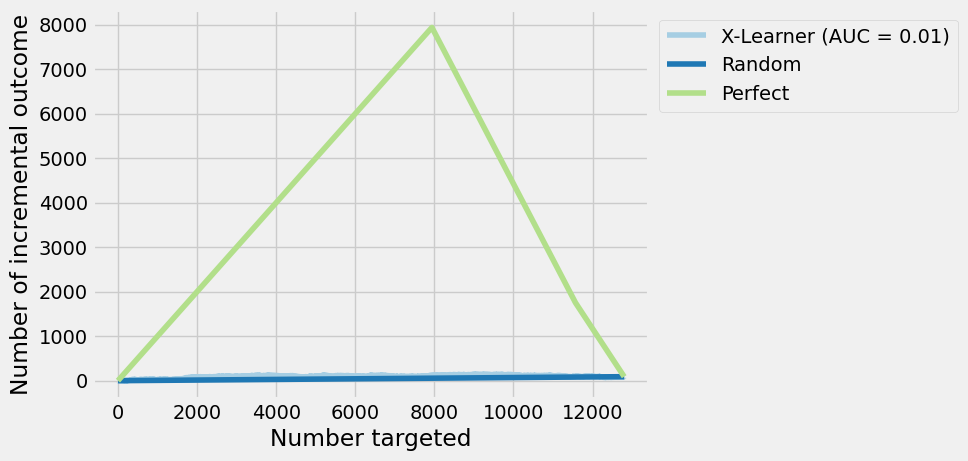

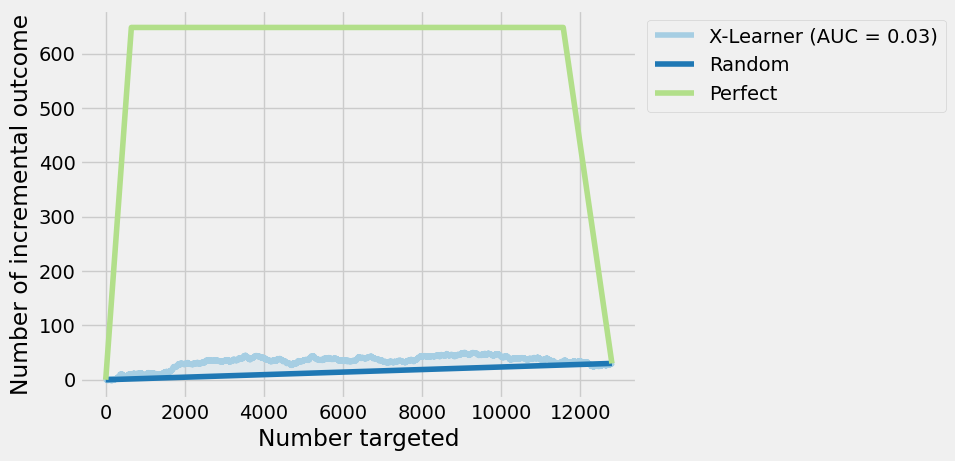

(0.013775835704670574, 0.031154409021974805, 0.032869611713464364)

In [20]:
params_clf = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
params_rgs = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}

x_learner = XLearner(params_clf, params_rgs, control_name=0)
x_learner.compute_propensity_scores(X_train, X_test)
x_learner.fit(X_train, X_test, y_train, y_test, X_train['treatment'])
x_learner.predict(X_test)
x_learner.evaluate(y_test, X_test)

Проинтерпретируйте полученные результаты и обоснуйте выбор 1 модели в этой ячейке

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

In [21]:
# One-hot encoding of categorical features
# as X-learner convert data to numpy arrays internally (no column names), 
# thus its impossible to pass cat_features to CatBoost models

def one_hot_encoding(df, cat_features):
    '''
        One-hot encoding of categorical features
    '''
    
    df_encoded = df.copy()

    for col in cat_features:
        df_encoded[col] = df_encoded[col].astype(str)

    df_encoded = pd.get_dummies(df_encoded, columns=cat_features, drop_first=True)
    
    return df_encoded

In [22]:
# One-hot encoding of categorical features of original dataset

cat_original_to_encode = [
    'history_segment', 
    'mens',
    'womens',
    'zip_code', 
    'newbie',
    'channel'
    ]

X_train_encoded = one_hot_encoding(X_train, cat_original_to_encode)
X_test_encoded = one_hot_encoding(X_test, cat_original_to_encode)

print(f"\nTrain set shape: {X_train_encoded.shape}")
print(f"Test set shape: {X_test_encoded.shape}")


Train set shape: (51200, 16)
Test set shape: (12800, 16)


Uplift AUC: 0.01
Qini AUC: 0.03
Uplift@30: 0.0312


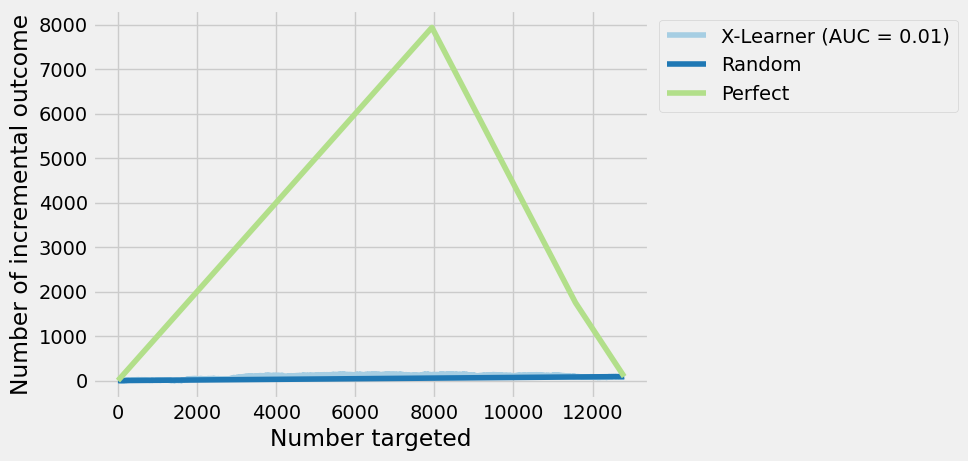

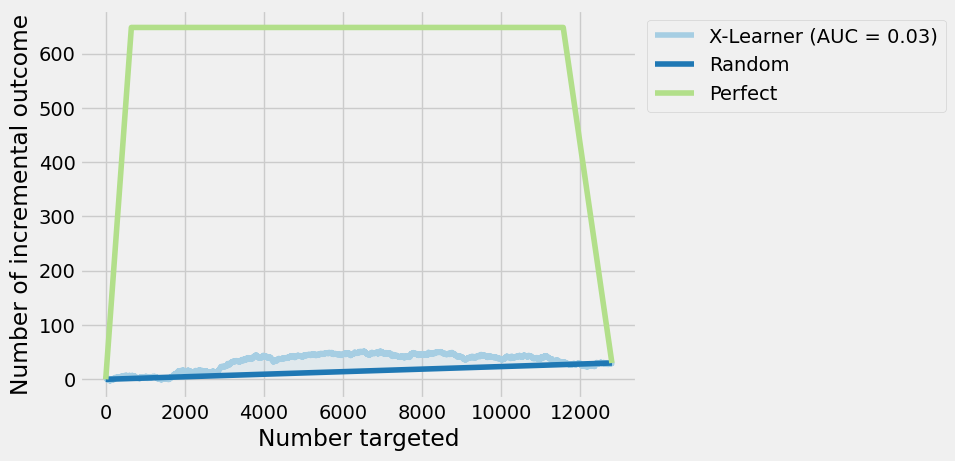

(0.013420108953534014, 0.030489118866351007, 0.031213841277225485)

In [23]:
# Retrain X-learner with one-hot encoded features
params_clf = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
params_rgs = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
x_learner = XLearner(params_clf, params_rgs, control_name=0)
x_learner.compute_propensity_scores(X_train_encoded, X_test_encoded)
x_learner.fit(
    X_train_encoded, 
    X_test_encoded, 
    y_train, 
    y_test, 
    X_train_encoded['treatment']
)
x_learner.predict(X_test_encoded)
x_learner.evaluate(y_test, X_test_encoded)

#### Генерация признаков

In [24]:
# Feature preprocessing and engineering for model improvement
# Based on feature importances and correlations analysis

def features_engineering(df):
    '''
        Create engineered features based on EDA insights:
        - history and history_segment are highly correlated
        - mens and womens are highly correlated
        - recency is second most important
        - zip_code and channel are important categoricals
    '''

    df_engineered = df.copy()
    
    # Interaction feature: history per recency (combines top 2 important features)
    df_engineered['history_per_recency'] = df_engineered['history'] / (df_engineered['recency'] + 1)
    
    # Log transform of history (reduces effect of right-skewness)
    df_engineered['log_history'] = np.log1p(df_engineered['history'])
    
    # Customer gender preference (reduces effect of multicollinearity between mens and womens)
    # 0 = neither, 1 = mens only, 2 = womens only, 3 = both
    df_engineered['gender_type'] = df_engineered['mens'].astype(int) + 2 * df_engineered['womens'].astype(int)
    
    # Recency bins (negative correlation with target)
    df_engineered['recency_bin'] = pd.cut(df_engineered['recency'], bins=[0, 3, 6, 9, 12], labels=[0, 1, 2, 3]).astype(int)
    
    # History bins (positive correlation with target)
    df_engineered['history_bin'] = pd.qcut(df_engineered['history'], q=4, labels=[0, 1, 2, 3], duplicates='drop').astype(int)
    
    # Newbie and recency interaction (both have negative correlation with target)
    df_engineered['newbie_recency'] = df_engineered['newbie'].astype(int) * df_engineered['recency']
    
    # High value customer flag (history > median)
    history_median = df_engineered['history'].median()
    df_engineered['high_value'] = (df_engineered['history'] > history_median).astype(int)
    
    return df_engineered

In [25]:
# Apply feature engineering to train and test sets

X_train_engineered = features_engineering(X_train)
X_test_engineered = features_engineering(X_test)

In [26]:
# One-hot encode categorical features of feature engineered dataset

cat_engineered_to_encode = [
    'history_segment', 
    'zip_code', 
    'channel', 
    'gender_type', 
    'recency_bin', 
    'history_bin'
    ]

X_train_engineered_encoded = one_hot_encoding(X_train_engineered, cat_engineered_to_encode)
X_test_engineered_encoded = one_hot_encoding(X_test_engineered, cat_engineered_to_encode)

## Ensure both have same columns (handle any missing dummies)
#missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
#for col in missing_cols:
#    X_test_encoded[col] = 0
#X_test_encoded = X_test_encoded[X_train_encoded.columns]
#
## Convert all to numeric (handle any remaining bool/category)
#for col in X_train_encoded.columns:
#    if X_train_encoded[col].dtype == bool or X_train_encoded[col].dtype.name == 'category':
#        X_train_encoded[col] = X_train_encoded[col].astype(int)
#        X_test_encoded[col] = X_test_encoded[col].astype(int)

print(f"\nNew feature columns:")
print([col for col in X_train_engineered_encoded.columns if col not in X_train.columns][:20])
print(f"\nTrain set shape: {X_train_engineered_encoded.shape}")
print(f"Test set shape: {X_test_engineered_encoded.shape}")


New feature columns:
['history_per_recency', 'log_history', 'newbie_recency', 'high_value', 'history_segment_1', 'history_segment_2', 'history_segment_3', 'history_segment_4', 'history_segment_5', 'history_segment_6', 'zip_code_1', 'zip_code_2', 'channel_1', 'channel_2', 'gender_type_2', 'gender_type_3', 'recency_bin_1', 'recency_bin_2', 'recency_bin_3', 'history_bin_1']

Train set shape: (51200, 28)
Test set shape: (12800, 28)


Uplift AUC: 0.02
Qini AUC: 0.04
Uplift@30: 0.0298


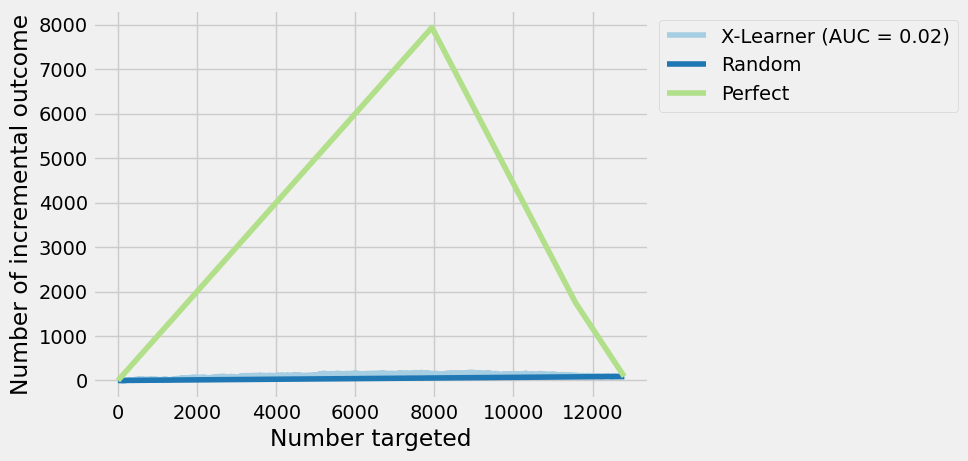

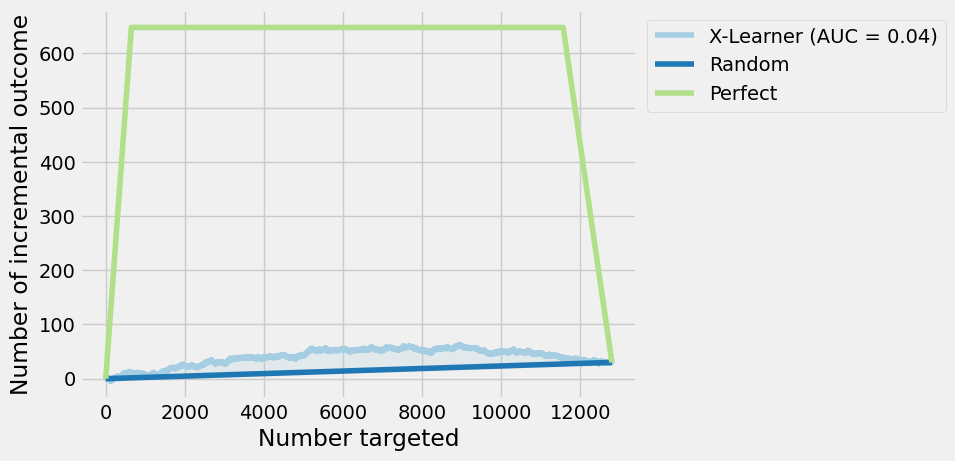

(0.018460760018898563, 0.042077932915505954, 0.029848699137698942)

In [27]:
# Retrain X-learner with engineered and one-hot encoded features
params_clf = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
params_rgs = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
x_learner = XLearner(params_clf, params_rgs, control_name=0)
x_learner.compute_propensity_scores(X_train_engineered_encoded, X_test_engineered_encoded)
x_learner.fit(
    X_train_engineered_encoded, 
    X_test_engineered_encoded, 
    y_train, 
    y_test, 
    X_train_engineered_encoded['treatment']
)
x_learner.predict(X_test_engineered_encoded)
x_learner.evaluate(y_test, X_test_engineered_encoded)

### Подбор гиперпараметров

In [28]:
# Compute propensity scores for Optuna optimization using XLearner static method
# Propensity score = P(treatment=1 | X)
# Note: Propensity scores depend on the features, so use the same features 
# (engineered + encoded) that you'll use for the X-Learner model
x_learner = XLearner(params_clf, params_rgs, control_name=0)
propensity_train, propensity_test = x_learner.compute_propensity_scores(X_train_engineered_encoded, X_test_engineered_encoded)

#print(f"Propensity train shape: {propensity_train.shape}")
#print(f"Propensity test shape: {propensity_test.shape}")
#print(f"Propensity train mean: {propensity_train.mean():.4f}")
#print(f"Propensity test mean: {propensity_test.mean():.4f}")


In [29]:
try:
    print(propensity_train.head())
except:
    print(propensity_train)

[0.3091751  0.30271146 0.44641107 ... 0.22022246 0.33329526 0.3975063 ]


In [30]:
# Hyperparameters tuning using Optuna

def objective(trial, propensity_train, propensity_test):
    '''
        Objective function for Optuna
    '''
    
    # Hyperparameters to tune for CatBoostClassifier (prefixed with clf_)
    params_clf = {
        'iterations': trial.suggest_int('clf_iterations', 100, 1000),
        'depth': trial.suggest_int('clf_depth', 4, 10),
        'learning_rate': trial.suggest_float('clf_learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('clf_l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_seed': 42,
        'verbose': 0,
        'auto_class_weights': 'Balanced'
    }

    # Hyperparameters to tune for CatBoostRegressor (prefixed with rgs_)
    params_rgs = {
        'iterations': trial.suggest_int('rgs_iterations', 100, 1000),
        'depth': trial.suggest_int('rgs_depth', 4, 10),
        'learning_rate': trial.suggest_float('rgs_learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('rgs_l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_seed': 42,
        'verbose': 0,
    }
    
    # Create CatBoost models with trial parameters
    cb_clf = CatBoostClassifier(**params_clf)
    cb_rgs = CatBoostRegressor(**params_rgs)
    
    # Train X-Learner with tuned CatBoost
    x_learner_trial = BaseXClassifier(
        outcome_learner=cb_clf, 
        control_name=0,
        effect_learner=cb_rgs
    )
    
    x_learner_trial.fit(
        X=X_train_engineered_encoded.values,
        treatment=X_train_engineered_encoded['treatment'].values,
        y=y_train.astype(int).values,
        p=propensity_train
    )
    
    # Predict uplift
    uplift_pred = x_learner_trial.predict(
        X_test_engineered_encoded.values.copy(), 
        p=propensity_test
        ).squeeze()
    
    # Calculate uplift@30%
    uplift_at_30 = uplift_at_k(
        y_test.astype(int).values, 
        uplift_pred, 
        X_test_engineered_encoded['treatment'].values, 
        k=0.3, 
        strategy='overall'
    )

    return uplift_at_30

# Create and run the study with lambda to pass additional arguments
study = optuna.create_study(direction='maximize')
study.optimize(
    lambda trial: objective(trial, propensity_train, propensity_test), 
    n_trials=50, 
    show_progress_bar=True
)

# Print best hyperparameters
print(f"Best hyperparameters: {study.best_params}")
print(f"Best score: {study.best_value}")

[I 2025-12-24 02:27:00,157] A new study created in memory with name: no-name-692dd1ca-1925-4f68-ad5d-12b6a6bd202b
Best trial: 0. Best value: 0.0392993:   2%|▏         | 1/50 [00:25<21:07, 25.88s/it]

[I 2025-12-24 02:27:26,032] Trial 0 finished with value: 0.03929932225107055 and parameters: {'clf_iterations': 264, 'clf_depth': 6, 'clf_learning_rate': 0.032399123762445525, 'clf_l2_leaf_reg': 0.0029591793224406538, 'rgs_iterations': 570, 'rgs_depth': 10, 'rgs_learning_rate': 0.029878927478943346, 'rgs_l2_leaf_reg': 0.027290492187893377}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:   4%|▍         | 2/50 [01:22<35:10, 43.96s/it]

[I 2025-12-24 02:28:22,651] Trial 1 finished with value: 0.01897546897546898 and parameters: {'clf_iterations': 978, 'clf_depth': 10, 'clf_learning_rate': 0.12143914508269564, 'clf_l2_leaf_reg': 0.27405447333865923, 'rgs_iterations': 270, 'rgs_depth': 6, 'rgs_learning_rate': 0.11012169731054208, 'rgs_l2_leaf_reg': 3.1527720226725076}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:   6%|▌         | 3/50 [02:01<32:46, 41.83s/it]

[I 2025-12-24 02:29:01,950] Trial 2 finished with value: 0.03745346168974617 and parameters: {'clf_iterations': 338, 'clf_depth': 4, 'clf_learning_rate': 0.2842628359628924, 'clf_l2_leaf_reg': 0.005362886524772718, 'rgs_iterations': 914, 'rgs_depth': 10, 'rgs_learning_rate': 0.03428236430326416, 'rgs_l2_leaf_reg': 0.04989322789791443}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:   8%|▊         | 4/50 [02:09<21:43, 28.34s/it]

[I 2025-12-24 02:29:09,612] Trial 3 finished with value: 0.03193784595285998 and parameters: {'clf_iterations': 215, 'clf_depth': 5, 'clf_learning_rate': 0.021634995024214985, 'clf_l2_leaf_reg': 0.0036265971159137314, 'rgs_iterations': 906, 'rgs_depth': 4, 'rgs_learning_rate': 0.08845047899539943, 'rgs_l2_leaf_reg': 0.20309715630470465}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:  10%|█         | 5/50 [02:19<16:25, 21.90s/it]

[I 2025-12-24 02:29:20,087] Trial 4 finished with value: 0.036889834303627425 and parameters: {'clf_iterations': 377, 'clf_depth': 7, 'clf_learning_rate': 0.014228340659079224, 'clf_l2_leaf_reg': 0.006802477572344444, 'rgs_iterations': 694, 'rgs_depth': 5, 'rgs_learning_rate': 0.04201273246261255, 'rgs_l2_leaf_reg': 1.0413908498613207}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:  12%|█▏        | 6/50 [02:40<15:49, 21.58s/it]

[I 2025-12-24 02:29:41,043] Trial 5 finished with value: 0.03515392598440584 and parameters: {'clf_iterations': 419, 'clf_depth': 9, 'clf_learning_rate': 0.03648075006682967, 'clf_l2_leaf_reg': 0.11209242257430474, 'rgs_iterations': 527, 'rgs_depth': 7, 'rgs_learning_rate': 0.15010074529689044, 'rgs_l2_leaf_reg': 0.006608449054540943}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:  14%|█▍        | 7/50 [02:55<13:48, 19.27s/it]

[I 2025-12-24 02:29:55,546] Trial 6 finished with value: 0.025407183676385503 and parameters: {'clf_iterations': 148, 'clf_depth': 10, 'clf_learning_rate': 0.08346483213062347, 'clf_l2_leaf_reg': 0.8398807115255518, 'rgs_iterations': 784, 'rgs_depth': 6, 'rgs_learning_rate': 0.0400107839107717, 'rgs_l2_leaf_reg': 4.243683093070261}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:  16%|█▌        | 8/50 [03:06<11:39, 16.65s/it]

[I 2025-12-24 02:30:06,585] Trial 7 finished with value: 0.036967175902701405 and parameters: {'clf_iterations': 215, 'clf_depth': 8, 'clf_learning_rate': 0.034735119015997656, 'clf_l2_leaf_reg': 0.1383046215758113, 'rgs_iterations': 721, 'rgs_depth': 6, 'rgs_learning_rate': 0.11612144596516202, 'rgs_l2_leaf_reg': 0.034042003711715514}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:  18%|█▊        | 9/50 [03:19<10:37, 15.54s/it]

[I 2025-12-24 02:30:19,686] Trial 8 finished with value: 0.031362510665750964 and parameters: {'clf_iterations': 343, 'clf_depth': 8, 'clf_learning_rate': 0.04056177572172902, 'clf_l2_leaf_reg': 0.047657073239112974, 'rgs_iterations': 887, 'rgs_depth': 5, 'rgs_learning_rate': 0.0646025098964924, 'rgs_l2_leaf_reg': 0.01111923055673852}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 0. Best value: 0.0392993:  20%|██        | 10/50 [03:41<11:36, 17.42s/it]

[I 2025-12-24 02:30:41,314] Trial 9 finished with value: 0.03785867560140044 and parameters: {'clf_iterations': 785, 'clf_depth': 5, 'clf_learning_rate': 0.01339665926389536, 'clf_l2_leaf_reg': 0.006358705097671018, 'rgs_iterations': 559, 'rgs_depth': 9, 'rgs_learning_rate': 0.07729396128816496, 'rgs_l2_leaf_reg': 0.02094311845953567}. Best is trial 0 with value: 0.03929932225107055.


Best trial: 10. Best value: 0.0436053:  22%|██▏       | 11/50 [03:52<10:08, 15.60s/it]

[I 2025-12-24 02:30:52,799] Trial 10 finished with value: 0.04360533080373867 and parameters: {'clf_iterations': 630, 'clf_depth': 6, 'clf_learning_rate': 0.07395883735080903, 'clf_l2_leaf_reg': 5.129840508879475, 'rgs_iterations': 107, 'rgs_depth': 9, 'rgs_learning_rate': 0.013355748474904418, 'rgs_l2_leaf_reg': 0.0012427880046305532}. Best is trial 10 with value: 0.04360533080373867.


Best trial: 11. Best value: 0.046983:  24%|██▍       | 12/50 [04:04<09:09, 14.45s/it] 

[I 2025-12-24 02:31:04,610] Trial 11 finished with value: 0.04698300200549076 and parameters: {'clf_iterations': 643, 'clf_depth': 6, 'clf_learning_rate': 0.08212702983707289, 'clf_l2_leaf_reg': 7.833895438412146, 'rgs_iterations': 114, 'rgs_depth': 9, 'rgs_learning_rate': 0.011850312537123249, 'rgs_l2_leaf_reg': 0.0010320339579317002}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  26%|██▌       | 13/50 [04:14<08:04, 13.10s/it]

[I 2025-12-24 02:31:14,600] Trial 12 finished with value: 0.042212556367774656 and parameters: {'clf_iterations': 622, 'clf_depth': 6, 'clf_learning_rate': 0.09319071026447505, 'clf_l2_leaf_reg': 9.948348255270002, 'rgs_iterations': 104, 'rgs_depth': 8, 'rgs_learning_rate': 0.01033747454949999, 'rgs_l2_leaf_reg': 0.0010033572539222006}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  28%|██▊       | 14/50 [04:24<07:19, 12.20s/it]

[I 2025-12-24 02:31:24,710] Trial 13 finished with value: 0.044901191488042724 and parameters: {'clf_iterations': 599, 'clf_depth': 6, 'clf_learning_rate': 0.2401928060134954, 'clf_l2_leaf_reg': 6.814731607452367, 'rgs_iterations': 112, 'rgs_depth': 8, 'rgs_learning_rate': 0.011422903842043147, 'rgs_l2_leaf_reg': 0.0011768542509584335}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  30%|███       | 15/50 [04:41<07:55, 13.58s/it]

[I 2025-12-24 02:31:41,488] Trial 14 finished with value: 0.021567106470252007 and parameters: {'clf_iterations': 792, 'clf_depth': 7, 'clf_learning_rate': 0.19835112686922776, 'clf_l2_leaf_reg': 1.515312627167871, 'rgs_iterations': 276, 'rgs_depth': 8, 'rgs_learning_rate': 0.2993974797771488, 'rgs_l2_leaf_reg': 0.0035517708673525675}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  32%|███▏      | 16/50 [04:51<07:02, 12.41s/it]

[I 2025-12-24 02:31:51,200] Trial 15 finished with value: 0.04353203263360707 and parameters: {'clf_iterations': 525, 'clf_depth': 4, 'clf_learning_rate': 0.1609544169843633, 'clf_l2_leaf_reg': 2.754115778592322, 'rgs_iterations': 275, 'rgs_depth': 8, 'rgs_learning_rate': 0.016893277635283713, 'rgs_l2_leaf_reg': 0.2141085268992486}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  34%|███▍      | 17/50 [05:12<08:19, 15.15s/it]

[I 2025-12-24 02:32:12,715] Trial 16 finished with value: 0.03142981467517479 and parameters: {'clf_iterations': 750, 'clf_depth': 7, 'clf_learning_rate': 0.2585707651628089, 'clf_l2_leaf_reg': 0.5494921946891014, 'rgs_iterations': 365, 'rgs_depth': 9, 'rgs_learning_rate': 0.02184546815189851, 'rgs_l2_leaf_reg': 0.002561053405401742}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  36%|███▌      | 18/50 [05:22<07:13, 13.56s/it]

[I 2025-12-24 02:32:22,566] Trial 17 finished with value: 0.04541222336887972 and parameters: {'clf_iterations': 515, 'clf_depth': 5, 'clf_learning_rate': 0.05926797575509656, 'clf_l2_leaf_reg': 0.02791220179369774, 'rgs_iterations': 391, 'rgs_depth': 7, 'rgs_learning_rate': 0.010095921668912565, 'rgs_l2_leaf_reg': 0.003371085057853986}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  38%|███▊      | 19/50 [05:32<06:24, 12.39s/it]

[I 2025-12-24 02:32:32,243] Trial 18 finished with value: 0.03697886168849833 and parameters: {'clf_iterations': 471, 'clf_depth': 5, 'clf_learning_rate': 0.05478165244478576, 'clf_l2_leaf_reg': 0.04184256299176563, 'rgs_iterations': 409, 'rgs_depth': 7, 'rgs_learning_rate': 0.018602888395072435, 'rgs_l2_leaf_reg': 0.005063569483992846}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  40%|████      | 20/50 [05:44<06:14, 12.50s/it]

[I 2025-12-24 02:32:44,989] Trial 19 finished with value: 0.03364136129166824 and parameters: {'clf_iterations': 916, 'clf_depth': 4, 'clf_learning_rate': 0.053377218892769994, 'clf_l2_leaf_reg': 0.0010019941997839764, 'rgs_iterations': 432, 'rgs_depth': 7, 'rgs_learning_rate': 0.024907818617460043, 'rgs_l2_leaf_reg': 0.09373486057524646}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  42%|████▏     | 21/50 [06:01<06:42, 13.89s/it]

[I 2025-12-24 02:33:02,127] Trial 20 finished with value: 0.03430938156951176 and parameters: {'clf_iterations': 715, 'clf_depth': 5, 'clf_learning_rate': 0.13101470568798676, 'clf_l2_leaf_reg': 0.020767066867813197, 'rgs_iterations': 235, 'rgs_depth': 10, 'rgs_learning_rate': 0.015324261936433027, 'rgs_l2_leaf_reg': 0.010093345080597114}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  44%|████▍     | 22/50 [06:13<06:07, 13.12s/it]

[I 2025-12-24 02:33:13,457] Trial 21 finished with value: 0.045979882278587056 and parameters: {'clf_iterations': 606, 'clf_depth': 6, 'clf_learning_rate': 0.05867641077457255, 'clf_l2_leaf_reg': 8.482603715055538, 'rgs_iterations': 202, 'rgs_depth': 8, 'rgs_learning_rate': 0.010952717022576896, 'rgs_l2_leaf_reg': 0.001999757294805921}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  46%|████▌     | 23/50 [06:25<05:46, 12.83s/it]

[I 2025-12-24 02:33:25,593] Trial 22 finished with value: 0.04454899310463026 and parameters: {'clf_iterations': 531, 'clf_depth': 6, 'clf_learning_rate': 0.06034991351032539, 'clf_l2_leaf_reg': 2.7207366557392416, 'rgs_iterations': 188, 'rgs_depth': 9, 'rgs_learning_rate': 0.011077109960232827, 'rgs_l2_leaf_reg': 0.002060931154282295}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  48%|████▊     | 24/50 [06:38<05:31, 12.75s/it]

[I 2025-12-24 02:33:38,179] Trial 23 finished with value: 0.038151359830460155 and parameters: {'clf_iterations': 691, 'clf_depth': 5, 'clf_learning_rate': 0.106820974699302, 'clf_l2_leaf_reg': 0.017338457947775318, 'rgs_iterations': 360, 'rgs_depth': 8, 'rgs_learning_rate': 0.010015752423771031, 'rgs_l2_leaf_reg': 0.0025294440232160507}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  50%|█████     | 25/50 [06:57<06:07, 14.71s/it]

[I 2025-12-24 02:33:57,445] Trial 24 finished with value: 0.043386942112869684 and parameters: {'clf_iterations': 835, 'clf_depth': 8, 'clf_learning_rate': 0.02611258195277334, 'clf_l2_leaf_reg': 0.37595095935754286, 'rgs_iterations': 167, 'rgs_depth': 7, 'rgs_learning_rate': 0.019202159532648064, 'rgs_l2_leaf_reg': 0.00944553164179138}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  52%|█████▏    | 26/50 [07:15<06:19, 15.79s/it]

[I 2025-12-24 02:34:15,769] Trial 25 finished with value: 0.040178345898960924 and parameters: {'clf_iterations': 490, 'clf_depth': 6, 'clf_learning_rate': 0.06888232136770218, 'clf_l2_leaf_reg': 2.8633228491304914, 'rgs_iterations': 470, 'rgs_depth': 9, 'rgs_learning_rate': 0.014832294889184595, 'rgs_l2_leaf_reg': 0.0035566835547706155}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 11. Best value: 0.046983:  54%|█████▍    | 27/50 [07:29<05:48, 15.16s/it]

[I 2025-12-24 02:34:29,454] Trial 26 finished with value: 0.03230603982483682 and parameters: {'clf_iterations': 653, 'clf_depth': 7, 'clf_learning_rate': 0.04488969972655114, 'clf_l2_leaf_reg': 1.066812586023691, 'rgs_iterations': 319, 'rgs_depth': 7, 'rgs_learning_rate': 0.026711209778995125, 'rgs_l2_leaf_reg': 0.01501663955217355}. Best is trial 11 with value: 0.04698300200549076.


Best trial: 27. Best value: 0.0492811:  56%|█████▌    | 28/50 [07:38<04:56, 13.49s/it]

[I 2025-12-24 02:34:39,046] Trial 27 finished with value: 0.04928114899156098 and parameters: {'clf_iterations': 590, 'clf_depth': 5, 'clf_learning_rate': 0.024860866916911008, 'clf_l2_leaf_reg': 0.24296428030327813, 'rgs_iterations': 201, 'rgs_depth': 8, 'rgs_learning_rate': 0.013744812808973803, 'rgs_l2_leaf_reg': 0.0018768897655388258}. Best is trial 27 with value: 0.04928114899156098.


Best trial: 27. Best value: 0.0492811:  58%|█████▊    | 29/50 [07:47<04:12, 12.01s/it]

[I 2025-12-24 02:34:47,608] Trial 28 finished with value: 0.04588494220305239 and parameters: {'clf_iterations': 570, 'clf_depth': 4, 'clf_learning_rate': 0.01888423946504371, 'clf_l2_leaf_reg': 4.66429034973203, 'rgs_iterations': 191, 'rgs_depth': 8, 'rgs_learning_rate': 0.013256715813771369, 'rgs_l2_leaf_reg': 0.001810692843134306}. Best is trial 27 with value: 0.04928114899156098.


Best trial: 27. Best value: 0.0492811:  60%|██████    | 30/50 [08:01<04:12, 12.60s/it]

[I 2025-12-24 02:35:01,597] Trial 29 finished with value: 0.03673408483156233 and parameters: {'clf_iterations': 442, 'clf_depth': 6, 'clf_learning_rate': 0.026954810318678368, 'clf_l2_leaf_reg': 0.2189430177800223, 'rgs_iterations': 202, 'rgs_depth': 10, 'rgs_learning_rate': 0.029201383307916367, 'rgs_l2_leaf_reg': 0.628629515503396}. Best is trial 27 with value: 0.04928114899156098.


Best trial: 27. Best value: 0.0492811:  62%|██████▏   | 31/50 [08:19<04:28, 14.11s/it]

[I 2025-12-24 02:35:19,209] Trial 30 finished with value: 0.03300786273702505 and parameters: {'clf_iterations': 863, 'clf_depth': 7, 'clf_learning_rate': 0.010711557889506519, 'clf_l2_leaf_reg': 2.0493478738401265, 'rgs_iterations': 156, 'rgs_depth': 9, 'rgs_learning_rate': 0.052601250540891806, 'rgs_l2_leaf_reg': 0.005829796582022297}. Best is trial 27 with value: 0.04928114899156098.


Best trial: 27. Best value: 0.0492811:  64%|██████▍   | 32/50 [08:27<03:45, 12.55s/it]

[I 2025-12-24 02:35:28,114] Trial 31 finished with value: 0.046065097323467225 and parameters: {'clf_iterations': 583, 'clf_depth': 4, 'clf_learning_rate': 0.017283320904374653, 'clf_l2_leaf_reg': 4.881014576872615, 'rgs_iterations': 225, 'rgs_depth': 8, 'rgs_learning_rate': 0.013015490779894563, 'rgs_l2_leaf_reg': 0.001799130947511879}. Best is trial 27 with value: 0.04928114899156098.


Best trial: 27. Best value: 0.0492811:  66%|██████▌   | 33/50 [08:39<03:26, 12.15s/it]

[I 2025-12-24 02:35:39,349] Trial 32 finished with value: 0.04334782234503026 and parameters: {'clf_iterations': 705, 'clf_depth': 4, 'clf_learning_rate': 0.020906211427481163, 'clf_l2_leaf_reg': 8.627491439925922, 'rgs_iterations': 304, 'rgs_depth': 8, 'rgs_learning_rate': 0.021119570058905926, 'rgs_l2_leaf_reg': 0.0017614992359765063}. Best is trial 27 with value: 0.04928114899156098.


Best trial: 33. Best value: 0.0514411:  68%|██████▊   | 34/50 [08:51<03:14, 12.14s/it]

[I 2025-12-24 02:35:51,461] Trial 33 finished with value: 0.05144105934042505 and parameters: {'clf_iterations': 570, 'clf_depth': 5, 'clf_learning_rate': 0.016499498718875117, 'clf_l2_leaf_reg': 4.25926324887549, 'rgs_iterations': 227, 'rgs_depth': 9, 'rgs_learning_rate': 0.013046860148697256, 'rgs_l2_leaf_reg': 0.0011696360822850097}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  70%|███████   | 35/50 [09:08<03:25, 13.70s/it]

[I 2025-12-24 02:36:08,790] Trial 34 finished with value: 0.03988137691031156 and parameters: {'clf_iterations': 672, 'clf_depth': 5, 'clf_learning_rate': 0.016323977878220045, 'clf_l2_leaf_reg': 3.8345317728403114, 'rgs_iterations': 260, 'rgs_depth': 10, 'rgs_learning_rate': 0.014102281952381869, 'rgs_l2_leaf_reg': 0.0012749411405089293}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  72%|███████▏  | 36/50 [09:21<03:10, 13.58s/it]

[I 2025-12-24 02:36:22,111] Trial 35 finished with value: 0.04383296581754502 and parameters: {'clf_iterations': 554, 'clf_depth': 4, 'clf_learning_rate': 0.011199109525254712, 'clf_l2_leaf_reg': 0.9505940012892788, 'rgs_iterations': 330, 'rgs_depth': 9, 'rgs_learning_rate': 0.01754661596557266, 'rgs_l2_leaf_reg': 0.005280036078543419}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  74%|███████▍  | 37/50 [09:44<03:32, 16.33s/it]

[I 2025-12-24 02:36:44,835] Trial 36 finished with value: 0.04103458233470611 and parameters: {'clf_iterations': 377, 'clf_depth': 5, 'clf_learning_rate': 0.02801207282780348, 'clf_l2_leaf_reg': 0.5433011649681411, 'rgs_iterations': 480, 'rgs_depth': 10, 'rgs_learning_rate': 0.021720629800349445, 'rgs_l2_leaf_reg': 0.06824581659059474}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  76%|███████▌  | 38/50 [10:06<03:34, 17.90s/it]

[I 2025-12-24 02:37:06,408] Trial 37 finished with value: 0.04360295830421616 and parameters: {'clf_iterations': 583, 'clf_depth': 4, 'clf_learning_rate': 0.01571033836503423, 'clf_l2_leaf_reg': 1.661711366744583, 'rgs_iterations': 640, 'rgs_depth': 9, 'rgs_learning_rate': 0.034738289014200785, 'rgs_l2_leaf_reg': 0.02511452729336916}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  78%|███████▊  | 39/50 [10:22<03:10, 17.31s/it]

[I 2025-12-24 02:37:22,343] Trial 38 finished with value: 0.04115636986701454 and parameters: {'clf_iterations': 991, 'clf_depth': 5, 'clf_learning_rate': 0.018688196239034182, 'clf_l2_leaf_reg': 0.19076171480127235, 'rgs_iterations': 149, 'rgs_depth': 10, 'rgs_learning_rate': 0.012849351383003804, 'rgs_l2_leaf_reg': 0.9065653230658552}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  80%|████████  | 40/50 [10:29<02:22, 14.26s/it]

[I 2025-12-24 02:37:29,474] Trial 39 finished with value: 0.027038861256797803 and parameters: {'clf_iterations': 293, 'clf_depth': 4, 'clf_learning_rate': 0.022982341398924792, 'clf_l2_leaf_reg': 5.066147351000294, 'rgs_iterations': 231, 'rgs_depth': 8, 'rgs_learning_rate': 0.18789908123865148, 'rgs_l2_leaf_reg': 0.23305408310964607}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  82%|████████▏ | 41/50 [10:41<02:02, 13.66s/it]

[I 2025-12-24 02:37:41,729] Trial 40 finished with value: 0.04160418925465409 and parameters: {'clf_iterations': 446, 'clf_depth': 5, 'clf_learning_rate': 0.012844958382754517, 'clf_l2_leaf_reg': 0.35559969877154873, 'rgs_iterations': 971, 'rgs_depth': 6, 'rgs_learning_rate': 0.03739070818537012, 'rgs_l2_leaf_reg': 9.541337416290098}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  84%|████████▍ | 42/50 [10:52<01:41, 12.69s/it]

[I 2025-12-24 02:37:52,163] Trial 41 finished with value: 0.044850146233287785 and parameters: {'clf_iterations': 612, 'clf_depth': 6, 'clf_learning_rate': 0.04620366611642105, 'clf_l2_leaf_reg': 7.866465001991653, 'rgs_iterations': 141, 'rgs_depth': 8, 'rgs_learning_rate': 0.012119765652723295, 'rgs_l2_leaf_reg': 0.0016419844360881376}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  86%|████████▌ | 43/50 [11:06<01:32, 13.22s/it]

[I 2025-12-24 02:38:06,610] Trial 42 finished with value: 0.03731299955487605 and parameters: {'clf_iterations': 646, 'clf_depth': 6, 'clf_learning_rate': 0.0848826739319062, 'clf_l2_leaf_reg': 3.8413479416603424, 'rgs_iterations': 238, 'rgs_depth': 9, 'rgs_learning_rate': 0.016105751051657916, 'rgs_l2_leaf_reg': 0.0029345447072599774}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  88%|████████▊ | 44/50 [11:16<01:12, 12.13s/it]

[I 2025-12-24 02:38:16,202] Trial 43 finished with value: 0.04630486330561283 and parameters: {'clf_iterations': 569, 'clf_depth': 5, 'clf_learning_rate': 0.029914808354952454, 'clf_l2_leaf_reg': 6.1245735954795855, 'rgs_iterations': 214, 'rgs_depth': 8, 'rgs_learning_rate': 0.012380060649212809, 'rgs_l2_leaf_reg': 0.0011227955117132844}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  90%|█████████ | 45/50 [11:28<01:01, 12.28s/it]

[I 2025-12-24 02:38:28,843] Trial 44 finished with value: 0.045642363587318324 and parameters: {'clf_iterations': 405, 'clf_depth': 5, 'clf_learning_rate': 0.032298495489461496, 'clf_l2_leaf_reg': 1.4712683204855566, 'rgs_iterations': 315, 'rgs_depth': 9, 'rgs_learning_rate': 0.014956713011788157, 'rgs_l2_leaf_reg': 0.0011404106428957565}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  92%|█████████▏| 46/50 [11:34<00:41, 10.38s/it]

[I 2025-12-24 02:38:34,781] Trial 45 finished with value: 0.027868918864179526 and parameters: {'clf_iterations': 485, 'clf_depth': 4, 'clf_learning_rate': 0.03206127451318689, 'clf_l2_leaf_reg': 0.08097845444027668, 'rgs_iterations': 103, 'rgs_depth': 4, 'rgs_learning_rate': 0.012095960152297722, 'rgs_l2_leaf_reg': 0.0042837911771088635}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  94%|█████████▍| 47/50 [11:42<00:29,  9.73s/it]

[I 2025-12-24 02:38:42,983] Trial 46 finished with value: 0.044259005927952594 and parameters: {'clf_iterations': 103, 'clf_depth': 5, 'clf_learning_rate': 0.023243979001159203, 'clf_l2_leaf_reg': 6.049667962585899, 'rgs_iterations': 612, 'rgs_depth': 7, 'rgs_learning_rate': 0.024646202988892515, 'rgs_l2_leaf_reg': 0.008740283554110866}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  96%|█████████▌| 48/50 [12:12<00:31, 15.57s/it]

[I 2025-12-24 02:39:12,187] Trial 47 finished with value: 0.040054719562243504 and parameters: {'clf_iterations': 739, 'clf_depth': 9, 'clf_learning_rate': 0.015152192562077671, 'clf_l2_leaf_reg': 2.2838016857089314, 'rgs_iterations': 226, 'rgs_depth': 8, 'rgs_learning_rate': 0.018854124023087265, 'rgs_l2_leaf_reg': 0.0010942028750857966}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411:  98%|█████████▊| 49/50 [12:25<00:14, 14.90s/it]

[I 2025-12-24 02:39:25,514] Trial 48 finished with value: 0.036617796489780335 and parameters: {'clf_iterations': 574, 'clf_depth': 5, 'clf_learning_rate': 0.018849085109736336, 'clf_l2_leaf_reg': 0.6779345145969279, 'rgs_iterations': 283, 'rgs_depth': 9, 'rgs_learning_rate': 0.04401032125474833, 'rgs_l2_leaf_reg': 0.015541439036371086}. Best is trial 33 with value: 0.05144105934042505.


Best trial: 33. Best value: 0.0514411: 100%|██████████| 50/50 [12:33<00:00, 15.06s/it]

[I 2025-12-24 02:39:33,197] Trial 49 finished with value: 0.04116590807500631 and parameters: {'clf_iterations': 545, 'clf_depth': 4, 'clf_learning_rate': 0.03862120272993546, 'clf_l2_leaf_reg': 3.314816451200719, 'rgs_iterations': 136, 'rgs_depth': 8, 'rgs_learning_rate': 0.0125517236541794, 'rgs_l2_leaf_reg': 0.006787573262226822}. Best is trial 33 with value: 0.05144105934042505.
Best hyperparameters: {'clf_iterations': 570, 'clf_depth': 5, 'clf_learning_rate': 0.016499498718875117, 'clf_l2_leaf_reg': 4.25926324887549, 'rgs_iterations': 227, 'rgs_depth': 9, 'rgs_learning_rate': 0.013046860148697256, 'rgs_l2_leaf_reg': 0.0011696360822850097}
Best score: 0.05144105934042505


Best Classifier params: {'iterations': 570, 'depth': 5, 'learning_rate': 0.016499498718875117, 'l2_leaf_reg': 4.25926324887549, 'random_seed': 42, 'verbose': 0, 'auto_class_weights': 'Balanced'}
Best Regressor params: {'iterations': 227, 'depth': 9, 'learning_rate': 0.013046860148697256, 'l2_leaf_reg': 0.0011696360822850097, 'random_seed': 42, 'verbose': 0}
Best Optuna score (Uplift@30%): 0.0514
Uplift AUC: 0.02
Qini AUC: 0.05
Uplift@30: 0.0514


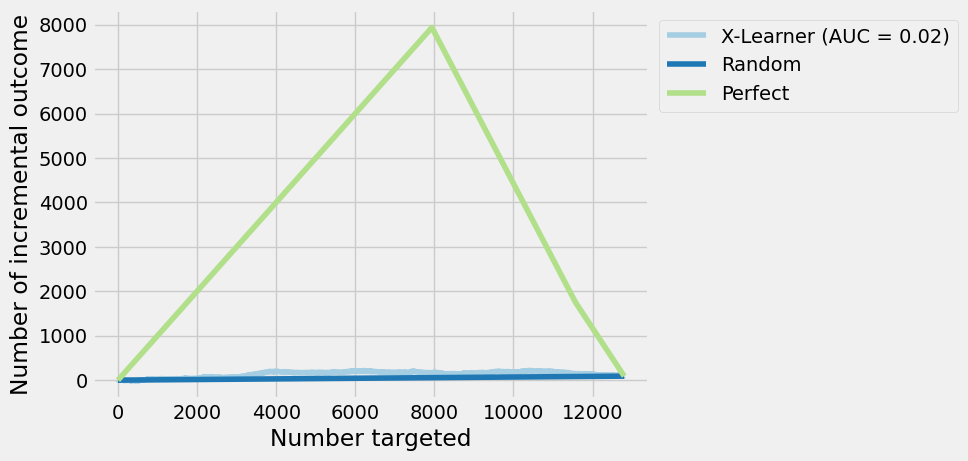

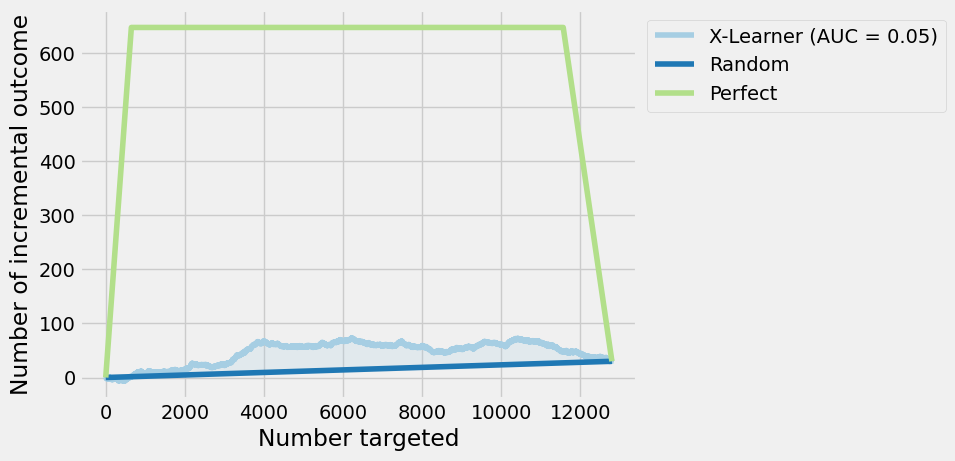

(0.023647022354421388, 0.05241637071419859, 0.05144105934042505)

In [31]:
# Train the final model with best hyperparameters

# Extract classifier parameters (prefixed with 'clf_')
best_params_clf = {
    'iterations': study.best_params['clf_iterations'],
    'depth': study.best_params['clf_depth'],
    'learning_rate': study.best_params['clf_learning_rate'],
    'l2_leaf_reg': study.best_params['clf_l2_leaf_reg'],
    'random_seed': 42,
    'verbose': 0,
    'auto_class_weights': 'Balanced'
}

# Extract regressor parameters (prefixed with 'rgs_')
best_params_rgs = {
    'iterations': study.best_params['rgs_iterations'],
    'depth': study.best_params['rgs_depth'],
    'learning_rate': study.best_params['rgs_learning_rate'],
    'l2_leaf_reg': study.best_params['rgs_l2_leaf_reg'],
    'random_seed': 42,
    'verbose': 0
}

print(f"Best Classifier params: {best_params_clf}")
print(f"Best Regressor params: {best_params_rgs}")
print(f"Best Optuna score (Uplift@30%): {study.best_value:.4f}")

# Train final X-Learner with best hyperparameters
x_learner_final = XLearner(best_params_clf, best_params_rgs, control_name=0)
x_learner_final.compute_propensity_scores(X_train_engineered_encoded, X_test_engineered_encoded)
x_learner_final.fit(
    X_train_engineered_encoded, 
    X_test_engineered_encoded, 
    y_train, 
    y_test, 
    X_train_engineered_encoded['treatment']
)
final_uplift = x_learner_final.predict(X_test_engineered_encoded)
x_learner_final.evaluate(y_test, X_test_engineered_encoded)

In [32]:
## Hyperparameters tuning using Optna
#
#def objective(trial):
#    '''
#        Objective function for Optuna
#    '''
#    
#    # Hyperparameters to tune for CatBoost
#    params = {
#        'iterations': trial.suggest_int('iterations', 100, 1000),
#        'depth': trial.suggest_int('depth', 4, 10),
#        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
#        'random_seed': 42,
#        'verbose': 0,
#        'auto_class_weights': 'Balanced'
#    }
#    
#    # Create CatBoost model with trial parameters
#    treatment_cat_model = CatBoostClassifier(
#                **params
#                )
#
#    control_cat_model = CatBoostClassifier(
#                **params
#                )
#    
#    # Train T-Learner with tuned CatBoost
#    tlearner_trial = BaseTClassifier(
#        treatment_learner=treatment_cat_model, 
#        control_learner=control_cat_model, 
#        control_name=0
#        )
#    
#    # FIX: Use tlearner_trial (not t_learner) for fitting!
#    tlearner_trial.fit(
#        X=X_train_improved.values,               # Признаки БЕЗ treatment (all int types now)
#        treatment=X_train_encoded['treatment'].values,       # Столбец с признаком воздействия
#        y=y_train_int                               # Целевая переменная (int, not bool)
#    )
#    
#    # Predict uplift
#    uplift_pred = tlearner_trial.predict(X_test_improved.values.copy()).squeeze()
#    
#    # Calculate uplift@30%
#    uplift_at_30 = uplift_at_k(y_test_int, uplift_pred, X_test_encoded['treatment'].values, k=0.3, strategy='overall')
#    return uplift_at_30
#
## Create and run the study
#study = create_study(direction='maximize')
#study.optimize(objective, n_trials=50, show_progress_bar=True)
#
## Print best hyperparameters
#print("Best hyperparameters: ", study.best_params)
#print("Best score: ", study.best_value)

In [33]:
## Train the final model with best hyperparameters
#best_params = study.best_params.copy()
#best_params['random_seed'] = 42
#best_params['verbose'] = 0
#best_params['auto_class_weights'] = 'Balanced'
#
## IMPORTANT: Create SEPARATE model instances for treatment and control!
## Using the same instance causes models to share state incorrectly
#best_treatment_model = CatBoostClassifier(**best_params)
#best_control_model = CatBoostClassifier(**best_params)
#
#best_tlearner = BaseTClassifier(
#    treatment_learner=best_treatment_model,
#    control_learner=best_control_model,
#    control_name=0
#    )
#best_tlearner.fit(X_train_improved.values, X_train_encoded['treatment'].values, y_train_int)
#
## Get final predictions
#final_uplift = best_tlearner.predict(X_test_improved.values.copy()).squeeze()
#
## Evaluate the tuned model
#print("=== Tuned BaseTLearner Results ===")
#tuned_auc = uplift_auc_score(y_test_int, final_uplift, X_test_encoded['treatment'].values)
#print(f"Uplift AUC: {tuned_auc:.4f}")
#
#tuned_qini = qini_auc_score(y_test_int, final_uplift, X_test_encoded['treatment'].values)
#print(f"Qini AUC: {tuned_qini:.4f}")
#
#tuned_uplift_30 = uplift_at_k(y_test_int, final_uplift, X_test_encoded['treatment'].values, strategy='overall', k=0.3)
#print(f"Uplift@30: {tuned_uplift_30:.4f}")
#
## Compare with baseline
#baseline_auc = uplift_auc_score(y_test_int, uplift_pred_baseline, X_test['treatment'].values)
#print(f"\nBaseline Uplift AUC: {baseline_auc:.4f}")
#print(f"Improvement: {(tuned_auc - baseline_auc) / baseline_auc * 100:.2f}%")


In [34]:
#def objective(trial):
#    # Hyperparameters to tune for CatBoost
#    params = {
#        'iterations': trial.suggest_int('iterations', 100, 1000),
#        'depth': trial.suggest_int('depth', 4, 10),
#        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
#        'random_seed': 42,
#        'verbose': 0,
#        'auto_class_weights': 'Balanced'
#    }
#    
#    gb_clf = CatBoostClassifier(
#                    iterations=500, 
#                    depth=6, 
#                    learning_rate=0.1,
#                    auto_class_weights='Balanced', 
#                    random_seed=42, 
#                    verbose=0
#    )
#
#    gb_reg = CatBoostRegressor(
#                        iterations=500, 
#                        depth=6, 
#                        learning_rate=0.1,
#                        random_seed=42, 
#                        verbose=0
#    )
#
#    # для propensity score используем XGBoost
#    propensity_model = XGBClassifier(
#        random_state=42,
#        n_estimators=200,
#        max_depth=10,
#        learning_rate=0.1,
#        use_label_encoder=False,
#        eval_metric='logloss',
#        n_jobs=-1,
#        verbosity=0
#    )
#    propensity_model.fit(X_train_no_treatment.values, X_train['treatment'].values)
#    # получаем propensity score для train и test
#    p_train = propensity_model.predict_proba(X_train_no_treatment.values)[:, 1]
#    p_test = propensity_model.predict_proba(X_test_no_treatment.values)[:, 1]
#        
#    # Train T-Learner with tuned CatBoost
#    tlearner_trial = BaseTClassifier(
#        treatment_learner=treatment_cat_model, 
#        control_learner=control_cat_model, 
#        control_name=0
#        )
#    
#    # FIX: Use tlearner_trial (not t_learner) for fitting!
#    tlearner_trial.fit(
#        X=X_train_improved.values,               # Признаки БЕЗ treatment (all int types now)
#        treatment=X_train_encoded['treatment'].values,       # Столбец с признаком воздействия
#        y=y_train_int                               # Целевая переменная (int, not bool)
#    )
#    
#    # Predict uplift
#    uplift_pred = tlearner_trial.predict(X_test_improved.values.copy()).squeeze()
#    
#    # Calculate uplift@30%
#    uplift_at_30 = uplift_at_k(y_test_int, uplift_pred, X_test_encoded['treatment'].values, k=0.3, strategy='overall')
#    return uplift_at_30
#
## Create and run the study
#study = create_study(direction='maximize')
#study.optimize(objective, n_trials=50, show_progress_bar=True)
#
## Print best hyperparameters
#print("Best hyperparameters: ", study.best_params)
#print("Best score: ", study.best_value)

Important context: An Uplift@30 of ~0.03-0.05 with a true treatment effect of only 0.7% means the model IS working - it's concentrating the effect in the top 30% to achieve 3-5% uplift vs 0.7% random. That's actually a 4-7x improvement in targeting efficiency!
The metrics appear "low" because the absolute numbers are small, but relative to the baseline treatment effect, this is meaningful uplift modeling.

Root Causes for Low Uplift@30 (0.0281)
1. The Treatment Effect is Inherently Very Small
From your z-test results in Cell 15:
Conversion rate control group: 0.144 (14.4%)Conversion rate treatment group: 0.151 (15.1%)
The overall treatment effect is only 0.7 percentage points (5% relative improvement). This is the fundamental ceiling - you can't extract a strong uplift signal when the underlying effect is this small.
2. Critical Bug in Cell 57 - Missing Propensity Score Computation
Looking at your final model training:
x_learner = XLearner(best_params_clf, best_params_rgs, control_name=0)x_learner.fit(...)  # ← propensity scores are None here!
You're NOT calling compute_propensity_scores() before fit(). This means self.propensity_train = None and self.propensity_test = None when the X-Learner is fitted. The Optuna search found 0.0492 because it used the pre-computed propensity scores, but your final model doesn't!
3. Homogeneous Treatment Effect
Looking at your correlation matrix and feature importances - the features don't seem to moderate the treatment effect strongly. If everyone responds similarly to treatment (no heterogeneous treatment effects), uplift models can't distinguish "persuadables" from others.
4. Imbalanced Treatment Groups
Control: 34,091 samples (67%)Treatment: 17,109 samples (33%)
This 2:1 imbalance may affect the model's ability to learn treatment effects accurately.

## Этап 2

### Визуализация результатов

In [35]:
from utils import custom_uplift_by_percentile

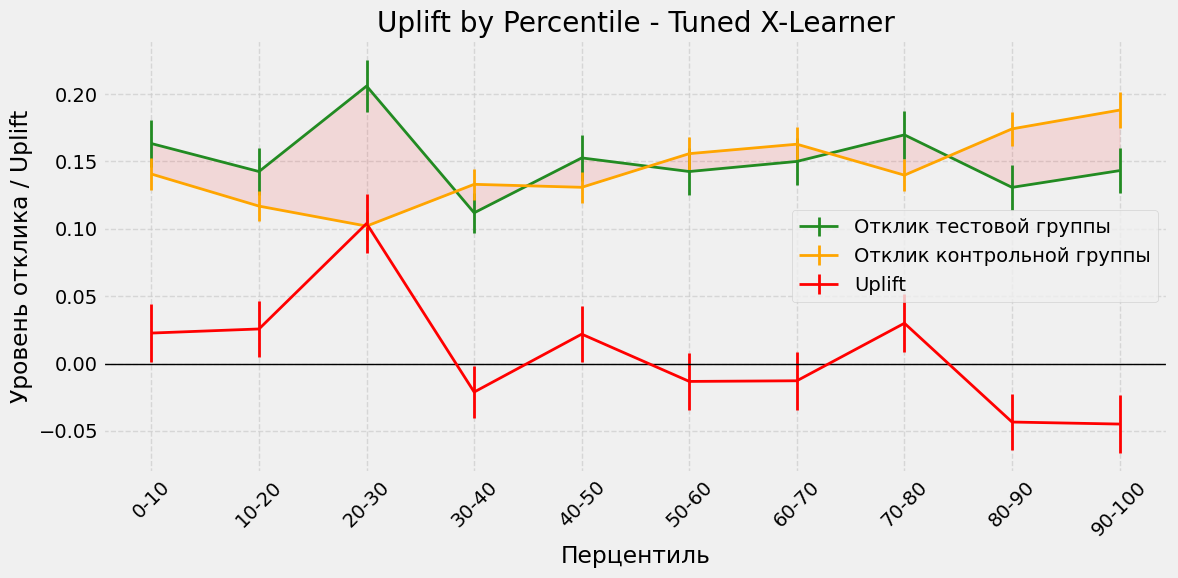

In [36]:
# Visualize uplift by percentile for tuned model
fig = custom_uplift_by_percentile(
    y_true=y_test, 
    uplift=final_uplift.squeeze(), 
    treatment=X_test_engineered_encoded['treatment'],
    kind='line',
    bins=10,
    string_percentiles=True,
    figsize=(12, 6),
    title='Uplift by Percentile - Tuned X-Learner'
)
plt.show()


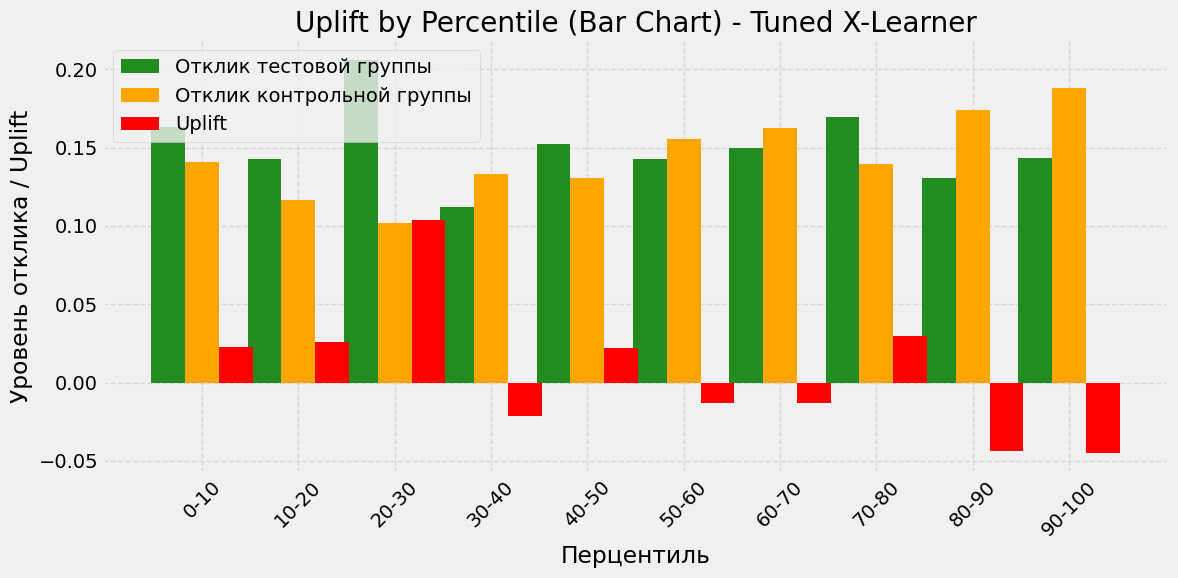

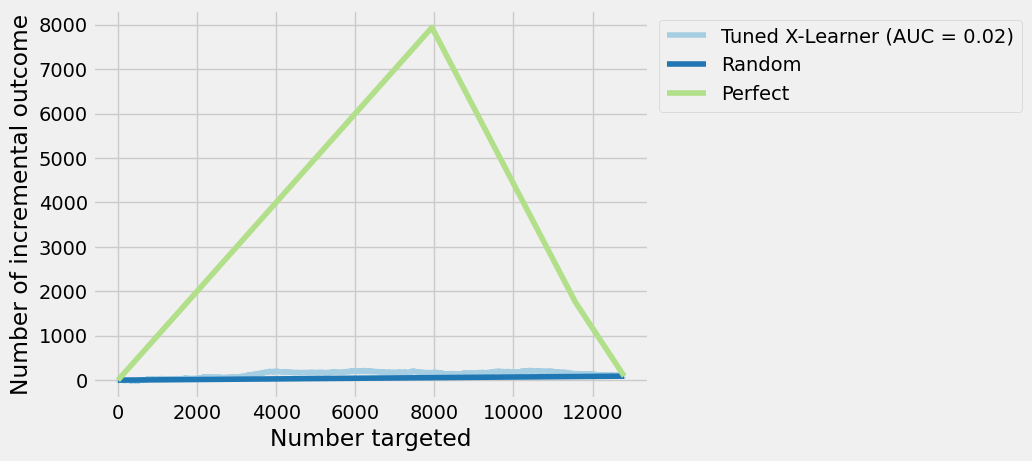

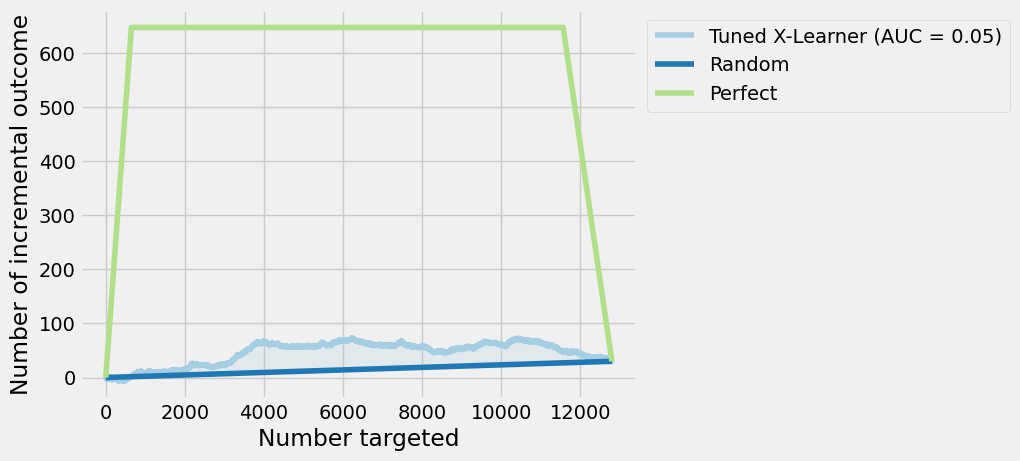

In [37]:
# Compare baseline vs tuned model with bar chart visualization
fig = custom_uplift_by_percentile(
    y_true=y_test, 
    uplift=final_uplift.squeeze(), 
    treatment=X_test_engineered_encoded['treatment'],
    kind='bar',
    bins=10,
    string_percentiles=True,
    figsize=(12, 6),
    title='Uplift by Percentile (Bar Chart) - Tuned X-Learner'
)
plt.show()

## Plot uplift and qini curves
#fig, axes = plt.subplots(1, 2, figsize=(14, 5))
#
## Uplift curve
#plt.sca(axes[0])
#plot_uplift_curve(
#    y_test.astype(int).values, 
#    final_uplift.squeeze(), 
#    X_test_engineered_encoded['treatment'], 
#    name='Tuned X-Learner'
#    )
#axes[0].set_title('Uplift Curve')
#
## Qini curve
#plt.sca(axes[1])
#plot_qini_curve(
#    y_test.astype(int).values, 
#    final_uplift.squeeze(), 
#    X_test_engineered_encoded['treatment'], 
#    name='Tuned X-Learner'
#    )
#axes[1].set_title('Qini Curve')
#
#plt.tight_layout()
#plt.show()

# Plot uplift curve
plot_uplift_curve(
    y_test.astype(int).values,
    final_uplift.squeeze(),
    X_test_engineered_encoded['treatment'], 
    name='Tuned X-Learner'
    )
plt.show()
# Plot Qini curve
plot_qini_curve(
    y_test.astype(int).values,
    final_uplift.squeeze(), 
    X_test_engineered_encoded['treatment'], 
    name='Tuned X-Learner'
    )
plt.show()

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [38]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    Принимает сырые данные и выполняет feature engineering + encoding внутри.
    """
    
    def __init__(self, model, raw_feature_names, training_columns, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift (должна иметь метод predict, принимающий numpy array)
            raw_feature_names: Список исходных признаков (до feature engineering)
            training_columns: Список колонок после one-hot encoding (из X_train, без 'treatment')
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.raw_feature_names = raw_feature_names
        # Remove 'treatment' from training columns - not needed for inference
        self.training_columns = [col for col in training_columns if col != 'treatment']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", raw_feature_names)

    def _feature_engineering(self, df):
        """
        Применение feature engineering (аналогично функции features_engineering).
        """
        df_engineered = df.copy()
        
        # Interaction feature: history per recency
        df_engineered['history_per_recency'] = df_engineered['history'] / (df_engineered['recency'] + 1)
        
        # Log transform of history
        df_engineered['log_history'] = np.log1p(df_engineered['history'])
        
        # Customer gender preference
        df_engineered['gender_type'] = df_engineered['mens'].astype(int) + 2 * df_engineered['womens'].astype(int)
        
        # Recency bins
        df_engineered['recency_bin'] = pd.cut(
            df_engineered['recency'], 
            bins=[0, 3, 6, 9, 12], 
            labels=[0, 1, 2, 3]
        ).astype(int)
        
        # History bins
        df_engineered['history_bin'] = pd.qcut(
            df_engineered['history'], 
            q=4, 
            labels=[0, 1, 2, 3], 
            duplicates='drop'
        ).astype(int)
        
        # Newbie and recency interaction
        df_engineered['newbie_recency'] = df_engineered['newbie'].astype(int) * df_engineered['recency']
        
        # High value customer flag (using approximate median from training)
        df_engineered['high_value'] = (df_engineered['history'] > 100).astype(int)
        
        return df_engineered

    def _transform_data(self, X):
        """
        Преобразование данных для модели: feature engineering + one-hot encoding + alignment.
        
        Аргументы:
            X: pandas.DataFrame с сырыми признаками
            
        Возвращает:
            numpy.ndarray: Преобразованные данные для модели
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # Step 1: Select only required raw features
        X = X[self.raw_feature_names].copy()
        
        # Step 2: Apply feature engineering
        X_engineered = self._feature_engineering(X)
        
        # Step 3: One-hot encoding
        cat_to_encode = [
            'history_segment', 
            'zip_code', 
            'channel', 
            'gender_type', 
            'recency_bin', 
            'history_bin'
        ]
        
        for col in cat_to_encode:
            if col in X_engineered.columns:
                X_engineered[col] = X_engineered[col].astype(str)
        
        X_encoded = pd.get_dummies(X_engineered, columns=cat_to_encode, drop_first=True)
        
        # Step 4: Align columns with training data
        # Add missing columns (filled with 0)
        for col in self.training_columns:
            if col not in X_encoded.columns:
                X_encoded[col] = 0
        
        # Keep only training columns in the correct order
        X_encoded = X_encoded[self.training_columns]
        
        return X_encoded.values
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с сырыми признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых RAW признаков
        missing_features = set(self.raw_feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)
            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X_transformed = self._transform_data(X)
        
        # Вычисляем propensity scores для новых данных
        if self.logger:
            self.logger.debug("Вычисляем propensity scores")
        
        # Use the stored propensity model to compute scores for new data
        propensity_scores = self.model.propensity_model.predict_proba(X_transformed)[:, 1]
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        
        # Get uplift predictions from the model's internal x_learner with propensity scores
        uplift = self.model.x_learner.predict(X_transformed, p=propensity_scores).squeeze()
        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [39]:
# Initialize the inference model with trained X-Learner
# Raw features expected as input (before feature engineering)
raw_feature_names = [
    'recency', 
    'history_segment', 
    'history', 
    'mens', 
    'womens', 
    'zip_code', 
    'newbie', 
    'channel'
]

# Training columns after feature engineering and encoding (excluding 'treatment')
training_columns = list(X_train_engineered_encoded.columns)

model_inference = UpliftModelInference(
    model=x_learner_final,
    raw_feature_names=raw_feature_names,
    training_columns=training_columns
)
print(f"Model initialized with {len(raw_feature_names)} raw features")
print(f"Model expects {len(model_inference.training_columns)} encoded features after transformation")

Model initialized with 8 raw features
Model expects 27 encoded features after transformation


In [40]:
# Create test data with raw features (as they would come from production)
test_data = pd.DataFrame({
    'recency': [1, 2, 3],
    'history_segment': [1, 2, 3], 
    'history': [100, 200, 300],
    'mens': [1, 0, 1],
    'womens': [0, 1, 0],
    'zip_code': [1, 0, 1],
    'newbie': [0, 1, 0],
    'channel': [1, 2, 0]
})

print("Test data (raw features):")
display(test_data)

Test data (raw features):


,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,1,1,100,1,0,1,0,1
1,2,2,200,0,1,0,1,2
2,3,3,300,1,0,1,0,0


In [41]:
# Проверка работы класса
# The class now handles feature engineering and encoding internally
predictions = model_inference.predict(test_data)
print("Uplift predictions for test data:")
print(predictions)

Uplift predictions for test data:
[-0.1940594  -0.12565861 -0.28144416]
